# **INTELIGENCIA ARTIFICIAL APLICADA A LA CIBERSEGURIDAD**
## **PRÁCTICA P1 - BLOQUE I**

**INSTRUCCIONES / RECOMENDACIONES**

- Se recomienda leer con detalle la descripción de cada una de las celdas.
- Las celdas que ya tienen código, se deberán ejecutar directamente.
- Las celdas que están vacías, se completarán con la implementación requerida en el notebook.
- No se incluirán más celdas de las establecidas en el presente notebook, por lo que la solución al mismo deberá implementarse exclusivamente en las celdas vacías.
- Scikit-Learn es un paquete muy útil para las operaciones de preprocesamiento de los datos, como estandarización, normalización, codificación y performance de los modelos.
- Si ves que un apartado es complejo, intenta escribir y ejecutarlo de forma simplificada (por ejemplo, con menos layers o con menos features) y después vaya ampliándolo.
- La entrega se realizará vía Moodle. Será necesario subir la solución a este notebook con el nombre: **NOMBRE_GRUPO.ipynb**

- **Fecha de Publicación: 12/02/2024**
- **Fecha de Entrega: 18/02/2024**
- **Test: 19/02/2024**


# Carga de librerías

In [43]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print(torch.__version__)

2.1.0+cu121


# Carga dataset

Se va a usar un dataset ('**creditcard.csv**') que contiene información sobre transacciones económicas, en donde cada una de las transacciones está etiquetada como caso de fraude o caso de no fraude.
El objetivo será construir un modelo MLP que permita detectar transacciones fraudulentas, tratándose por lo tanto de un problema de clasificación binaria.

El dataset se puede descargar desde el siguiente enlace:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download


In [44]:
# Download data from repository and unzip
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Pr%C3%A1ctica%201/creditcard.zip -O creditcard.zip
!unzip -o creditcard.zip

--2024-02-15 16:23:21--  https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Pr%C3%A1ctica%201/creditcard.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155672 (66M) [application/zip]
Saving to: ‘creditcard.zip’

creditcard.zip      100%[===================>]  65.95M   219MB/s    in 0.3s    

2024-02-15 16:23:22 (219 MB/s) - ‘creditcard.zip’ saved [69155672/69155672]

Archive:  creditcard.zip
  inflating: creditcard.csv          


# Preparación de los dataset de Train, Validation y Test

Se deberán crear los dataset **train_loader**, **val_loader** y **test_loader** (Entrenamiento, validación y test), especificando el parámetro **batch_size** que se empleará posteriormente durante el entrenamiento.

In [45]:
# DEFINE & CREATE DATASET

class CreditcardDataset(Dataset):

    def __init__(self, csv_file, transform=None):

        self.df = pd.read_csv(csv_file, sep=",")

        y = self.df.iloc[:]['Class'].values
        x = self.df.drop('Class', axis=1).values

        self.X = torch.tensor(x, dtype=torch.float32)
        self.Y = torch.tensor(y)

        self.transform = transform

        print(self.df.iloc[:]['Class'].value_counts())

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

CC_dataset = CreditcardDataset(csv_file='/content/creditcard.csv')



# PREPARE DATASETS
# Dataset balanceado

from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm

batch_size = 512
train_split = 0.8 # 80%
val_split = 0.5 # 50% del resto

train_size = int(train_split * len(CC_dataset))
val_size = int(val_split * (len(CC_dataset) - train_size))
test_size = len(CC_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(CC_dataset, [train_size, val_size, test_size])

# WeightedRandomSampler for TRAIN
class_0 = 0
class_1 = 0
train_labels = []
for i in range(len(train_dataset)):
    _, Y = train_dataset[i]

    if Y==0:
        class_0+=1
    else:
        class_1+=1

    train_labels.append(Y)

print ('TRAIN NO_FRAUD: ', class_0)
print ('TRAIN FRAUD:    ', class_1)

class_counts = [class_0, class_1]
num_samples = sum(class_counts)
labels = train_labels #train_dataset.Y #corresponding labels of samples
class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
train_sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

# WeightedRandomSampler for VAL
class_0 = 0
class_1 = 0
val_labels = []
for i in range(len(val_dataset)):
    _, Y = val_dataset[i]

    if Y==0:
        class_0+=1
    else:
        class_1+=1

    val_labels.append(Y)

print ('VAL NO_FRAUD: ', class_0)
print ('VAL FRAUD:    ', class_1)

class_counts = [class_0, class_1]
num_samples = sum(class_counts)
labels = val_labels
class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
val_sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

# WeightedRandomSampler for TEST
class_0 = 0
class_1 = 0
test_labels = []
for i in range(len(test_dataset)):
    _, Y = test_dataset[i]

    if Y==0:
        class_0+=1
    else:
        class_1+=1

    test_labels.append(Y)

print ('TEST NO_FRAUD: ', class_0)
print ('TEST FRAUD:    ', class_1)

class_counts = [class_0, class_1]
num_samples = sum(class_counts)
labels = test_labels #train_dataset.Y #corresponding labels of samples
class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
test_sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))


train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            #shuffle=True,
                            num_workers=0,
                            sampler=train_sampler
                            )
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            #shuffle=True,
                            num_workers=0,
                            sampler=val_sampler
                            )
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            #shuffle=True,
                            num_workers=0,
                            sampler=test_sampler
                            )

print ("# total samples:", len(CC_dataset))
print ("# total TRAIN samples:", len(train_loader.sampler))
print ("# total VAL samples:", len(val_loader.sampler))
print ("# total TEST samples:", len(test_loader.sampler))

0    284315
1       492
Name: Class, dtype: int64
TRAIN NO_FRAUD:  227437
TRAIN FRAUD:     408
VAL NO_FRAUD:  28441
VAL FRAUD:     40
TEST NO_FRAUD:  28437
TEST FRAUD:     44
# total samples: 284807
# total TRAIN samples: 227845
# total VAL samples: 28481
# total TEST samples: 28481


# Análisis del dataset

Realice un análisis de las variables en el dataset.
Sugerencias:
- Histogramas de las variables.
- Obtención de valores de centralidad y dispersión.
- Detectar variables que no parezcan predecir el target o si presentan alta correlación con alguna otra de las features.



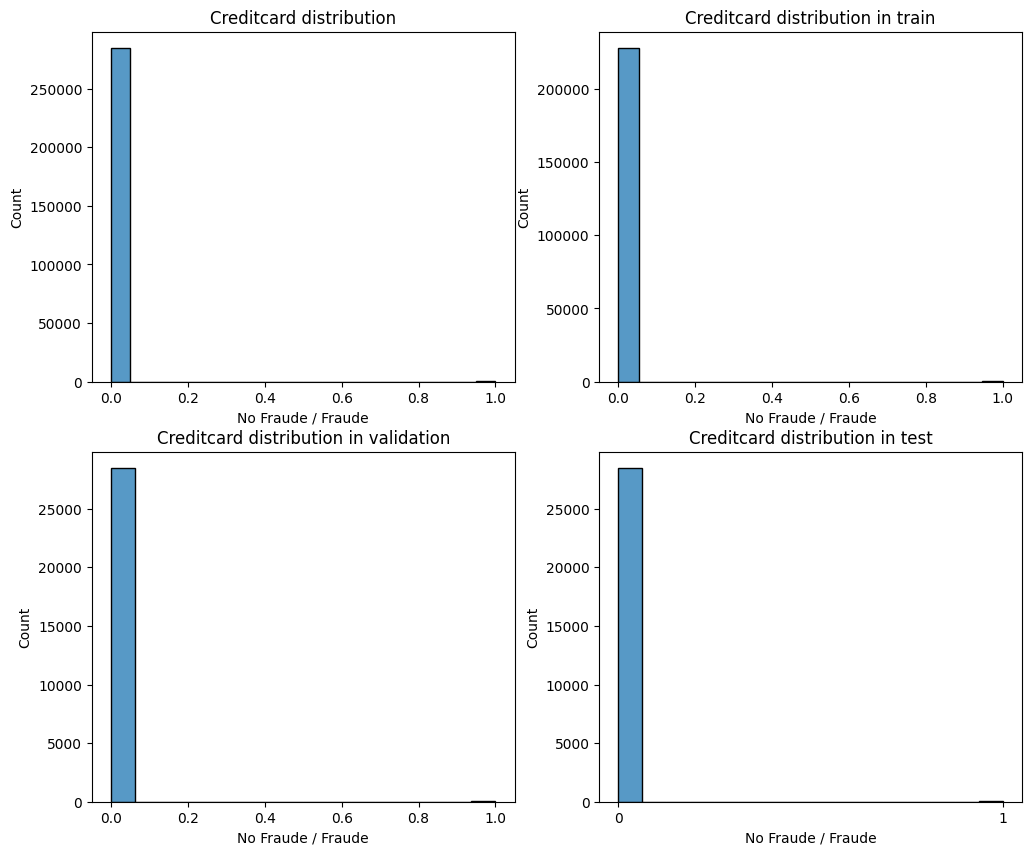

In [46]:
import seaborn as sns
# ==============================================================================
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
plt.xticks([0,1])
sns.histplot(data=CC_dataset.df, x='Class', kde=False,ax=ax[0][0])
ax[0][0].set_title("Creditcard distribution")
ax[0][0].set_xlabel('No Fraude / Fraude');

#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
plt.xticks([0,1])
sns.histplot(data=CC_dataset.df.iloc[train_dataset.indices], x='Class', kde=False,ax=ax[0][1])
ax[0][1].set_title("Creditcard distribution in train")
ax[0][1].set_xlabel('No Fraude / Fraude');


#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
plt.xticks([0,1])
sns.histplot(data=CC_dataset.df.iloc[val_dataset.indices], x='Class', kde=False,ax=ax[1][0])
ax[1][0].set_title("Creditcard distribution in validation")
ax[1][0].set_xlabel('No Fraude / Fraude');


#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
plt.xticks([0,1])
sns.histplot(data=CC_dataset.df.iloc[test_dataset.indices], x='Class', kde=False,ax=ax[1][1])
ax[1][1].set_title("Creditcard distribution in test")
ax[1][1].set_xlabel('No Fraude / Fraude');




array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>],
       [<Axes: title={'center': 'V3'}>, <Axes: title={'center': 'V4'}>,
        <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>],
       [<Axes: title={'center': 'V9'}>, <Axes: title={'center': 'V10'}>,
        <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>],
       [<Axes: title={'center': 'V15'}>, <Axes: title={'center': 'V16'}>,
        <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>],
       [<Axes: title={'center': 'V21'}>, <Axes: title={'center': 'V22'}>,
        <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
      

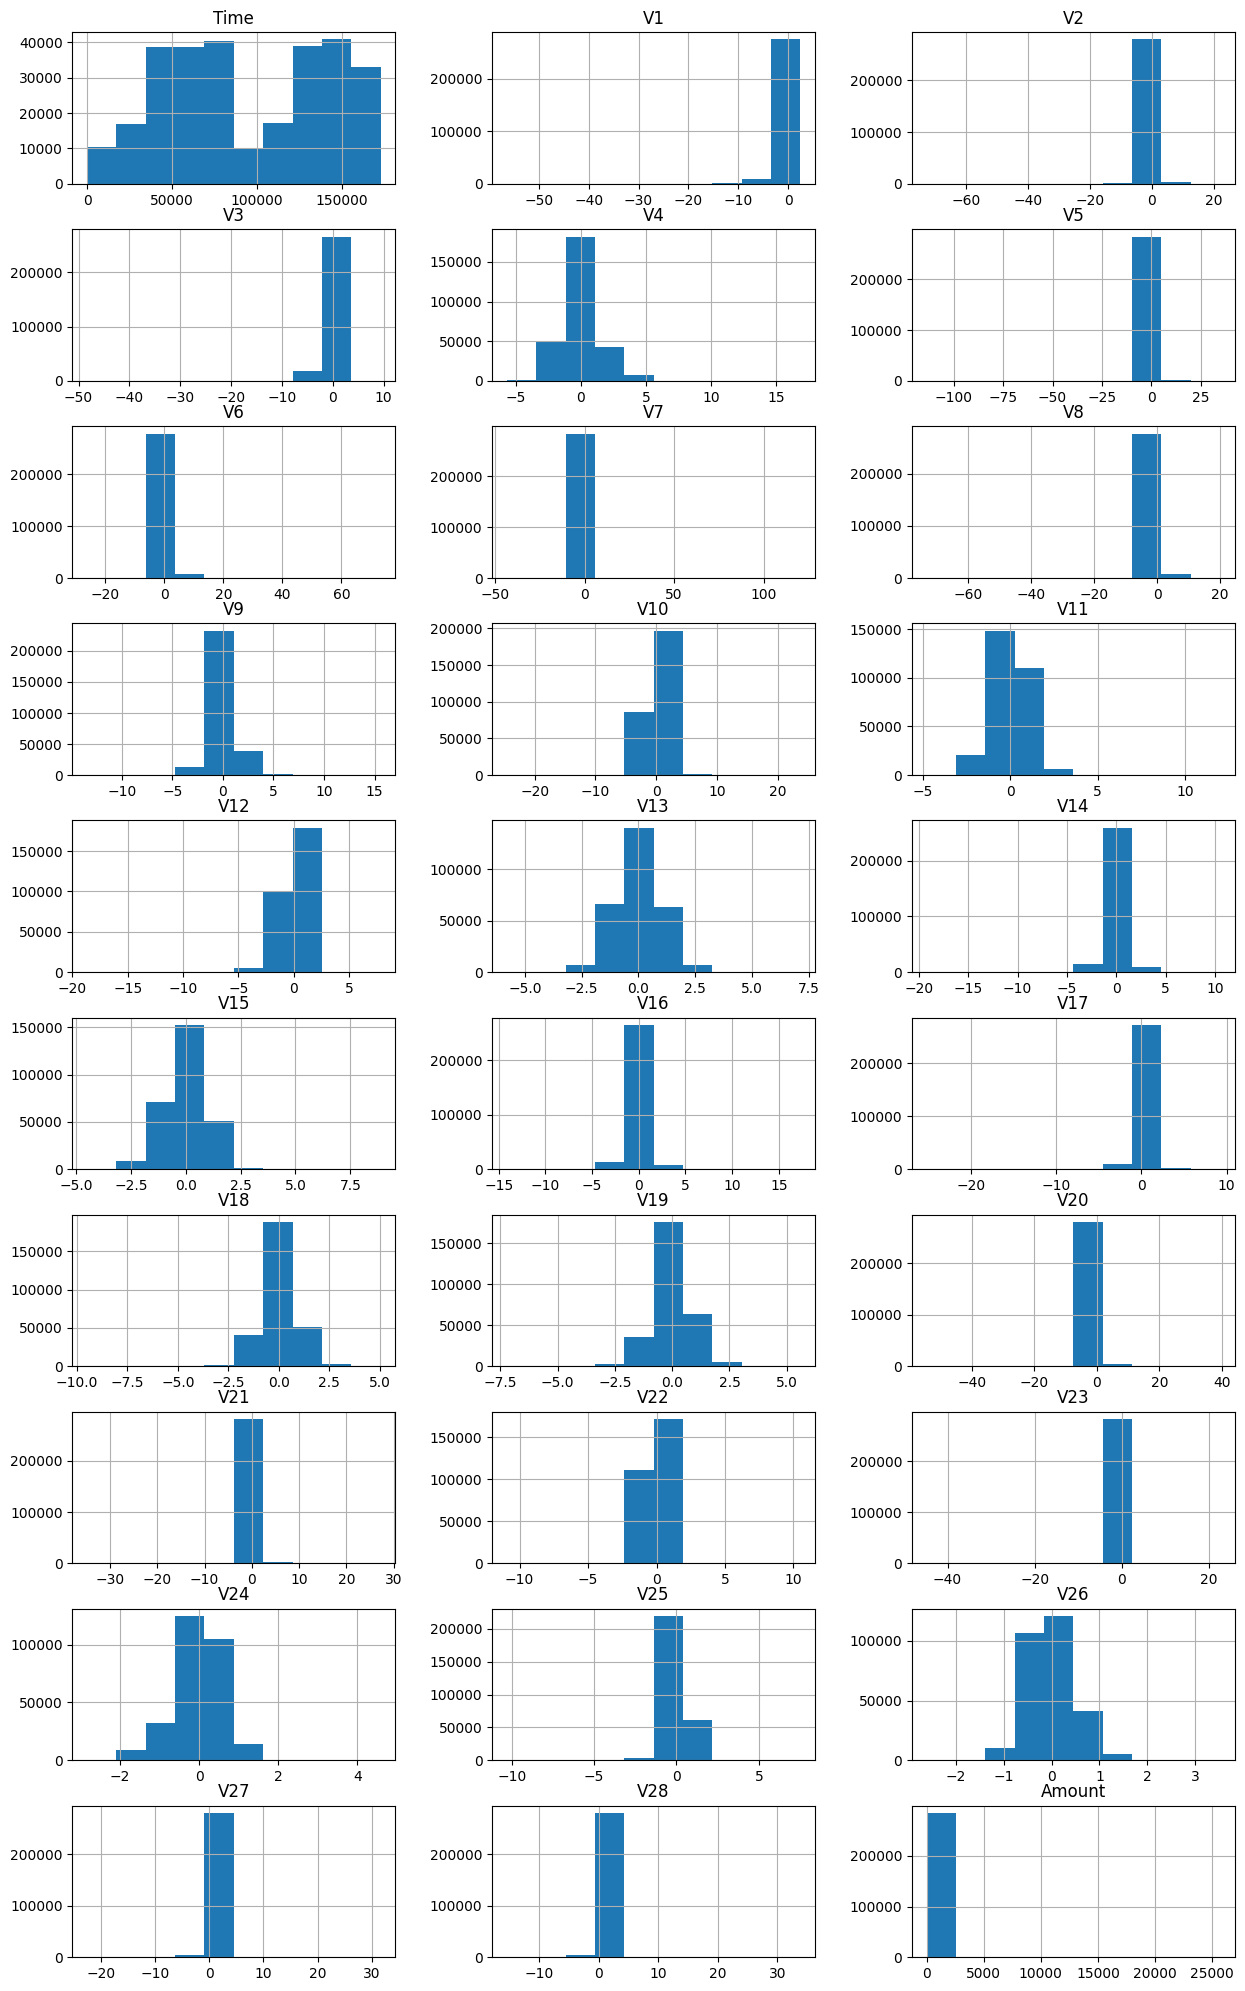

In [55]:
df_cols = CC_dataset.df.columns
df_cols = df_cols.drop("Class")
CC_dataset.df.get(df_cols).hist(figsize=(15,25), layout=(10,3))


<Axes: >

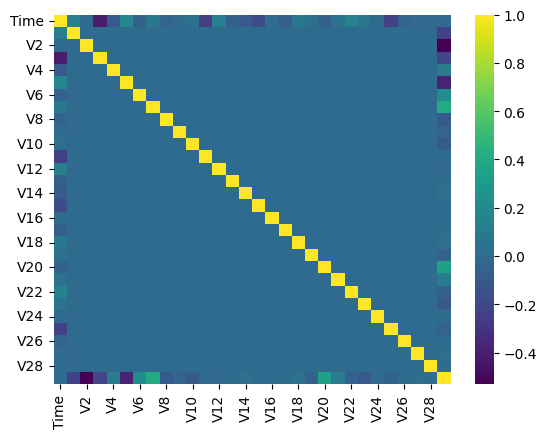

In [75]:
sns.heatmap(CC_dataset.df.get(df_cols).corr(),cmap='viridis')

# Activación de GPU

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'Tesla T4'

# Creación del modelo MLP

Se creará un modelo MLP denominado **model** que implementará un clasificador binario para la detección de transacciones fraudulentas.

In [81]:
# DEFINE NEURAL NETWORK MODEL

class FraudNet(nn.Module):
    def __init__(self):
      ## CAPAS DEL MODELO, LO IMPORTANTE ES DEFINIR TODAS LAS CAPAS SE VAN A USAR EN NUESTRO MODELO ##
        super(FraudNet, self).__init__()
        self.l1 = nn.Linear(30, 333) ## Red que coje 5 variables y va a una capa de 32 neuronas ##
        ## Es una buena práctica expandir la información, no mantener ni reducir ##
        self.l2 = nn.Linear(333, 2) ## Red que coje 32 variables y va a una capa de 2 neruonas, porque queremos dos salidas (fraude o no fraude) ##
        self.relu = nn.ReLU() ## Es una función de activación pero no se entrena ##
        ## Todos los datos negativos los pone a cero y a los positivos le aplica una relación lineal ##

        # Define proportion or neurons to dropout
        ## Coje el vector de entrada, aplica una probabilidad del 0.8 para conservar las conexiones entre capas, ##
        ## basicamente elimina el peso de la conexión ##
        self.dropout = nn.Dropout(0.8) ## Se necesita si tenemos sobreentrenamiento ##

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.dropout(x)
        out = self.l2(x)

        return out

model = FraudNet()
model.to(device)

print (model)

FraudNet(
  (l1): Linear(in_features=30, out_features=333, bias=True)
  (l2): Linear(in_features=333, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.8, inplace=False)
)


# Definición de función de pérdida y optimizador

Especificar el parámetro **lr** (learning rate) que se empleará durante el entrenamiento del modelo.

In [80]:
CC_dataset.df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# Definición de funciones de Entrenamiento y Validación

In [ ]:
def train_model(model, train_loader, criterion, optimizer, epoch):

    model.train()

    total_epoch_loss = 0
    total_epoch_acc = 0

    for i, (X, Y) in enumerate(train_loader):

        X, Y = X.to(device), Y.to(device)

        outputs = model(X)
        loss = criterion(outputs, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        num_corrects = (torch.max(outputs, 1)[1].view(Y.size()).data == Y.data).float().sum()
        acc = 100.0 * num_corrects/len(Y)

        if (i+1) % 1000 == 0:
          print (f'Epoch: {epoch+1}, Idx: ({i+1}/{len(train_loader)}), Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')

        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

    return total_epoch_loss/len(train_loader), total_epoch_acc/len(train_loader)

def eval_model(model, val_loader, criterion):

  model.eval()

  total_epoch_loss = 0
  total_epoch_acc = 0

  with torch.no_grad():

    for i, (X, Y) in enumerate(val_loader):

        X, Y = X.to(device), Y.to(device)

        outputs = model(X)
        loss = criterion(outputs, Y)

        num_corrects = (torch.max(outputs, 1)[1].view(Y.size()).data == Y.data).float().sum()
        acc = 100.0 * num_corrects/len(Y)

        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_loader), total_epoch_acc/len(val_loader)

# Entrenamiento del modelo

Especificar el parámetro **epochs** que se utilizará durante el entrenamiento del modelo.

In [ ]:
train_loss_epochs = []
val_loss_epochs = []
train_acc_epochs = []
val_acc_epochs = []

for epoch in range(epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, epoch)
    val_loss, val_acc = eval_model(model, val_loader, criterion)

    print(f'Epoch: [{epoch+1:02}/{epochs}], Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')
    train_loss_epochs.append(train_loss)
    val_loss_epochs.append(val_loss)
    train_acc_epochs.append(train_acc)
    val_acc_epochs.append(val_acc)

# Mostrar la evolución del error y del accuracy durante el entrenamiento del modelo

Para mostrar el error y accuracy del dataset de train y de val, haga uso de las listas creadas durante el entrenamiento del modelo (ver celda anterior).

# Verificar el rendimiento del modelo creado

Utilice el dataset de test para verificar el correcto rendimiento del modelo. Para ello puede emplear las métricas que considere oportunas, como por ejemplo Accuracy, Precision, Recall, F1-score o matriz de confusión.